# MobileNet

<a id='top'.</a>
[Table of contents](#bot)

- [Initialization](#init)
- [Data augmentation](#da)
- [Modeling](#mod)
    - [Base model](#bm)
    - [Generating features](#gf)
    - [Top model](#tm)
    - [Setting alternative top models](#atm) 
    - [Training the whole model](#wm)
    - [Visualizing predictions](#pred)
    
[Table of contents](#top) [Bottom](#bot)
<a id='init'.</a>

## Initialization

In [19]:
import sys
sys.path.append('../utils/')

import libraries
from libraries import *
import utils_functions
from utils_functions import *

%matplotlib inline

reload(libraries)
from libraries import *
reload(utils_functions)
from utils_functions import *

# checking
print(get_available_gpus())
print(psutil.virtual_memory())
print(keras.__version__)

['/gpu:0']
svmem(total=64390926336, available=61747615744, percent=4.1, used=2446176256, free=58821206016, active=2452750336, inactive=2459693056, buffers=19386368, cached=3104157696, shared=5046272)
2.0.6


#### Data loading

In [10]:
model = 'mobilenet'

# output directories
output = '../output'
models = 'models'
model_output = join(join(output, models), model)
model_output_weights = join(model_output, 'weights')

if not os.path.exists(output): os.mkdir(output)
if not os.path.exists(model_output): os.mkdir(model_output)
if not os.path.exists(model_output_weights): os.mkdir(model_output_weights)
    
# general variables
target_size = (256, 256)
target_size_mn = (224, 224)
num_classes = 1
input_shape = target_size + (3,)
input_shape_mn = target_size_mn + (3,)

path='../../data/sushi_or_sandwich/'

In [11]:
x_train, y_train, x_test, y_test, mean_set, std_set = \
load_data(path=path, target_size=target_size_mn, output_folder=output)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, mean_set, std_set)

Loading compressed data..
(640, 224, 224, 3) (640,) (160, 224, 224, 3) (160,) None None


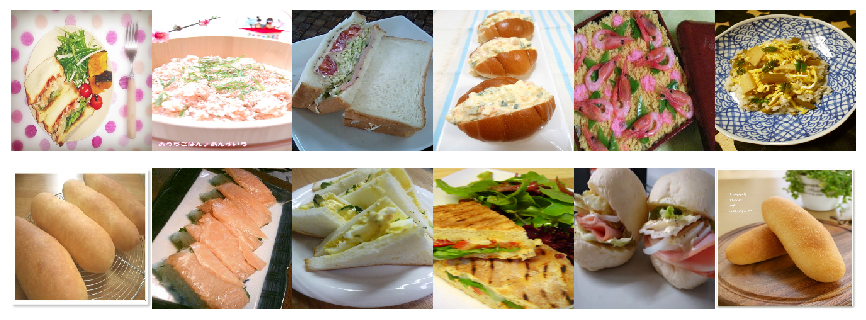

[0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [12]:
plot_images(x_train[:12]); print(list(y_train[:6])); print(list(y_train[6:12]))

[Table of contents](#top) [Bottom](#bottom)
<a id='da'.</a>

## Data augmentation

The process of data augmentation is performed by the following function contained in utils.py. It generates a set of ~2000 different data augmentation generators by iterating over an customizable value range for the following parameters/functions provided by the keras within the DataImageGenerator class:
- rotation_range
- width_shift_range     
- height_shift_range      
- shear_range             
- zoom_range              
- channel_shift_range        
- zca_whitening
- fill_mode                  
- horizontal_flip
- vertical_flip

Additionally it performs cropping of the images through the 'preprocessing_function'.

An example  of the images produced by a randomly selected generator is shown below.

Total number of available aug. data generators:  288
Selected number of aug. data generators:  75
0 <keras.preprocessing.image.ImageDataGenerator object at 0x7f6d2409a390>
Found 800 images belonging to 2 classes.
.
1 <keras.preprocessing.image.ImageDataGenerator object at 0x7f6d240930b8>
Found 800 images belonging to 2 classes.
.
2 <keras.preprocessing.image.ImageDataGenerator object at 0x7f6d240a0400>
Found 800 images belonging to 2 classes.
.
3 <keras.preprocessing.image.ImageDataGenerator object at 0x7f6d2413b0b8>
Found 800 images belonging to 2 classes.
.
4 <keras.preprocessing.image.ImageDataGenerator object at 0x7f6d240933c8>
Found 800 images belonging to 2 classes.
.
5 <keras.preprocessing.image.ImageDataGenerator object at 0x7f6d24112080>
Found 800 images belonging to 2 classes.
.
6 <keras.preprocessing.image.ImageDataGenerator object at 0x7f6ce80e5c50>


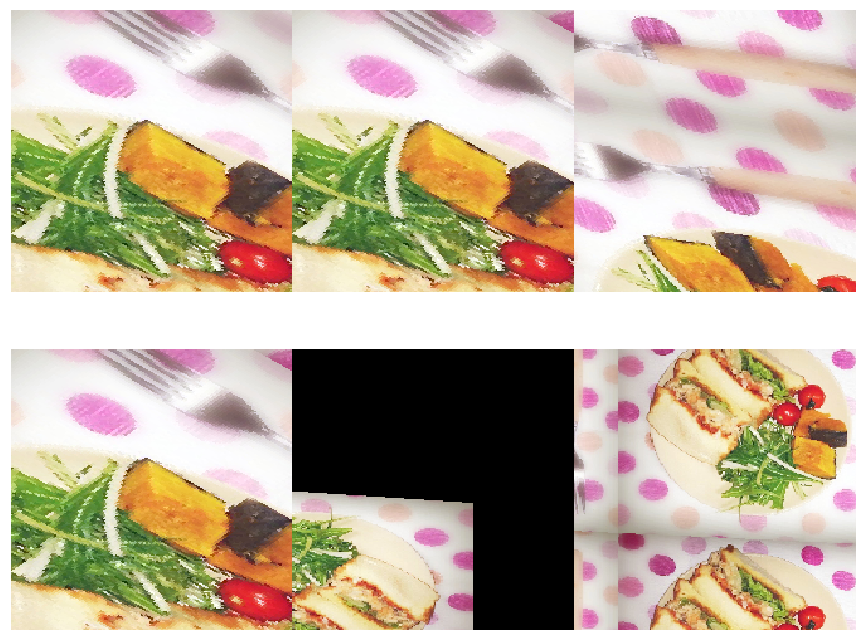

In [22]:
# 1. setting generators
n_gen = 75
ad_gens = aug_data_generators(model, n_gen)

# 2. saving a 120-image sample and plotting a sample
save_aug_data_sample(ad_gens, model, target_size_mn, path, output)

[Table of contents](#top) [Bottom](#bot)
<a id='mod'.</a>

## Modelling

<a id='bm'.</a>

##### 0.0. Setting the base model

In [23]:
input_shape = x_train.shape[1:]

bm = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape_mn)

<a id='gf'.</a>

##### 0.1. Generating features

In [24]:
# calculates the features/output of the selected base model

data={'x_train':x_train, 'y_train':y_train, 'x_test':x_test, 'y_test':y_test}

x_adf_train, y_adf_train, x_adf_test, y_adf_test = \
generate_aug_data_features(bm, ad_gens, data, model_output, batch_size=16, iters=1, verbose=False)

print(x_adf_train.shape, y_adf_train.shape, x_adf_test.shape, y_adf_test.shape)

Processing features..
Generator  1
Generator  2
Generator  3
Generator  4
Generator  5
Generator  6
Generator  7
Generator  8
Generator  9
Generator  11
Generator  12
Generator  13
Generator  14
Generator  15
Generator  16
Generator  17
Generator  18
Generator  19
Generator  21
Generator  22
Generator  23
Generator  24
Generator  25
Generator  26
Generator  27
Generator  28
Generator  29
Generator  31
Generator  32
Generator  33
Generator  34
Generator  35
Generator  36
Generator  37
Generator  38
Generator  39
Generator  41
Generator  42
Generator  43
Generator  44
Generator  45
Generator  46
Generator  47
Generator  48
Generator  49
Generator  51
Generator  52
Generator  53
Generator  54
Generator  55
Generator  56
Generator  57
Generator  58
Generator  59
Generator  61
Generator  62
Generator  63
Generator  64
Generator  65
Generator  66
Generator  67
Generator  68
Generator  69
Generator  71
Generator  72
Generator  73
Generator  74
(48000, 7, 7, 1024) (48000,) (12000, 7, 7, 1024) 

[Table of contents](#top) [Bottom](#bot)
<a id='tm'.</a>

##### 0.2. Setting and training a top model

In [36]:
# 0. setting up optimizers:
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam()

# # 1. setting callbacks
# # cyclical lr
# clr_triangular = CyclicLR(mode='triangular')
# clr_triangular = CyclicLR(mode='triangular2')
# clr_triangular = CyclicLR(mode='exp_range', gamma=0.99994)
# clr_triangular._reset()
# clr_triangular._reset(new_base_lr=0.003, new_max_lr=0.009)

# clr = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
# clr_triangular = CyclicLR(scale_fn=clr, scale_mode='cycle')
# clr = lambda x: 1/(5**(x*0.0001))
# clr_triangular = CyclicLR(scale_fn=clr, scale_mode='iterations')

callbacks = []

c_file = join(model_output, 'top_model_{p:.2f}-{val_loss:.2f}-{val_acc:.2f}.hdf5')

checkpoint = ModelCheckpoint(c_file, monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=True, mode='min')
callbacks.append(checkpoint)

l_file = join(model_output, 'top_model.log')
csv_logger = CSVLogger(l_file)

callbacks.append(csv_logger)

# plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [150]:
# dropout percentage

p = 0.8

top_m = Sequential([
        BatchNormalization(input_shape=bm.output_shape[1:]),
        GlobalAveragePooling2D(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1, activation='sigmoid')])

top_m.summary()

top_m.load_weights(join(model_output_weights, 'top_m_p50_0.3290_0.8562'))

top_m.compile(Adam(), loss='binary_crossentropy', 
              metrics=['accuracy', recall, precision, fmeasure])

top_m.evaluate(x_adf_test, y_adf_test, batch_size=batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_33 (Batc (None, 7, 7, 1024)        4096      
_________________________________________________________________
global_average_pooling2d_21  (None, 1024)              0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)               262400    
_________________________________________________________________
batch_normalization_34 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 257       
Total para

[0.32899388209978742,
 0.85616666682561238,
 0.82873241678873699,
 0.8576651465098063,
 0.84198422829310104]

In [151]:
top_m.optimizer.lr = 0.00001; print(top_m.optimizer.lr)

batch_size = 128
epochs = 1

top_m_h = top_m.fit(x_adf_train, y_adf_train, batch_size=batch_size, epochs=epochs,                  
                    validation_data=(x_adf_test, y_adf_test),
                    callbacks=callbacks)

1e-05
Train on 48000 samples, validate on 12000 samples
Epoch 1/1
48000/48000 [==============================] - 20s - loss: 0.5174 - acc: 0.7845 - recall: 0.8049 - precision: 0.7808 - fmeasure: 0.7909 - val_loss: 0.3315 - val_acc: 0.8548 - val_recall: 0.7823 - val_precision: 0.8913 - val_fmeasure: 0.8321


In [86]:
weights_file = 'top_m_p%2d_%.4f_%.4f' % (p*100, top_m_h.history['val_loss'][-1], top_m_h.history['val_acc'][-1])
top_m.save_weights(join(model_output_weights, weights_file))

In [ ]:
plot_hist(top_m_h, 'loss')
# plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

[Table of contents](#top) [Bottom](#bot)
<a id='atm'.</a>

##### 0.3. Setting and training alternative top models

#### Alternative 1: Removing the intermediate Dense layer

In [97]:
p = 0.5

# lighter top layer
top_m1 = Sequential([
         BatchNormalization(input_shape=bm.output_shape[1:]),
         GlobalAveragePooling2D(),
         Dropout(p),
         Dense(1, activation='sigmoid')])

top_m1.summary()

top_m1.compile(Adam(), loss='binary_crossentropy', 
               metrics=['accuracy', recall, precision, fmeasure])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_22 (Batc (None, 7, 7, 1024)        4096      
_________________________________________________________________
global_average_pooling2d_17  (None, 1024)              0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 1025      
Total params: 5,121
Trainable params: 3,073
Non-trainable params: 2,048
_________________________________________________________________


In [107]:
top_m1.optimizer.lr = 0.0001; print(top_m1.optimizer.lr)

batch_size = 128
epochs = 10

top_m1_h = top_m1.fit(x_adf_train, y_adf_train, batch_size=batch_size, epochs=epochs,                  
                      validation_data=(x_adf_test, y_adf_test),
                      callbacks=callbacks)

0.0001
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 18s - loss: 0.3558 - acc: 0.8379 - recall: 0.8379 - precision: 0.8446 - fmeasure: 0.8394 - val_loss: 0.3520 - val_acc: 0.8433 - val_recall: 0.8602 - val_precision: 0.8133 - val_fmeasure: 0.8353
Epoch 2/10
48000/48000 [==============================] - 18s - loss: 0.3579 - acc: 0.8372 - recall: 0.8373 - precision: 0.8440 - fmeasure: 0.8388 - val_loss: 0.3530 - val_acc: 0.8458 - val_recall: 0.8537 - val_precision: 0.8211 - val_fmeasure: 0.8364
Epoch 3/10
48000/48000 [==============================] - 18s - loss: 0.3587 - acc: 0.8372 - recall: 0.8383 - precision: 0.8435 - fmeasure: 0.8391 - val_loss: 0.3481 - val_acc: 0.8474 - val_recall: 0.8486 - val_precision: 0.8270 - val_fmeasure: 0.8369
Epoch 4/10
48000/48000 [==============================] - 18s - loss: 0.3562 - acc: 0.8379 - recall: 0.8372 - precision: 0.8449 - fmeasure: 0.8394 - val_loss: 0.3472 - val_acc: 0.8477 - v

In [108]:
weights_file = 'top_m1_p%2d_%.4f_%.4f' % (p*100, top_m1_h.history['val_loss'][-1], top_m1_h.history['val_acc'][-1])
top_m1.save_weights(join(model_output_weights, weights_file))

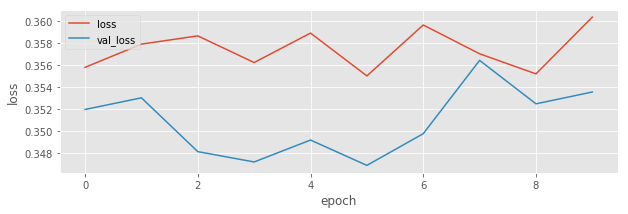

In [138]:
plot_hist(top_m1_h, 'loss')

#### Alternative 2: Removing the Dense layer and replacing with a Flatten layer

In [119]:
p = 0.5

top_m2 = Sequential([
         BatchNormalization(input_shape=bm.output_shape[1:]),
         Dropout(p),
         Flatten(),
         Dense(1, activation='sigmoid')])

top_m2.compile(Adam(), loss='binary_crossentropy', 
               metrics=['accuracy', recall, precision, fmeasure])

top_m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_26 (Batc (None, 7, 7, 1024)        4096      
_________________________________________________________________
dropout_37 (Dropout)         (None, 7, 7, 1024)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 50177     
Total params: 54,273
Trainable params: 52,225
Non-trainable params: 2,048
_________________________________________________________________


In [135]:
top_m2.optimizer.lr = 0.0001; print(top_m2.optimizer.lr)

batch_size = 128
epochs = 10

top_m2_h = top_m2.fit(x_adf_train, y_adf_train, batch_size=batch_size, epochs=epochs,                  
                      validation_data=(x_adf_test, y_adf_test),
                      callbacks=callbacks)

0.0001
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 21s - loss: 0.2424 - acc: 0.9165 - recall: 0.9191 - precision: 0.9184 - fmeasure: 0.9176 - val_loss: 0.6687 - val_acc: 0.8213 - val_recall: 0.8295 - val_precision: 0.7950 - val_fmeasure: 0.8109
Epoch 2/10
48000/48000 [==============================] - 21s - loss: 0.2485 - acc: 0.9149 - recall: 0.9173 - precision: 0.9173 - fmeasure: 0.9158 - val_loss: 0.6936 - val_acc: 0.8146 - val_recall: 0.8682 - val_precision: 0.7646 - val_fmeasure: 0.8122
Epoch 3/10
48000/48000 [==============================] - 21s - loss: 0.2288 - acc: 0.9183 - recall: 0.9211 - precision: 0.9200 - fmeasure: 0.9194 - val_loss: 0.6395 - val_acc: 0.8207 - val_recall: 0.8432 - val_precision: 0.7859 - val_fmeasure: 0.8128
Epoch 4/10
48000/48000 [==============================] - 21s - loss: 0.2355 - acc: 0.9152 - recall: 0.9175 - precision: 0.9181 - fmeasure: 0.9162 - val_loss: 0.6340 - val_acc: 0.8228 - v

In [136]:
weights_file = 'top_m2_p%2d_%.4f_%.4f' % (p*100, top_m2_h.history['val_loss'][-1], top_m2_h.history['val_acc'][-1])
top_m2.save_weights(join(model_output_weights, weights_file))

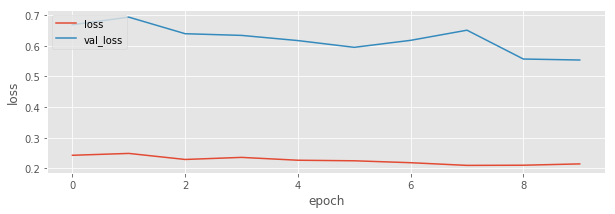

In [137]:
plot_hist(top_m2_h, 'loss')

#### Observations:
- Base model (MobileNet w/o top layer): 3.2M parameters.
- Top model: 265k parameters (86% val. acc.).
- Alternative 1 - Top model based on GloabalAveragePooling and a Dense layer, that is removing the convolutional layer: 3k. The validation accuracy just dropped by 1pp (85% val. acc.), while reducing the model architecture in 262k parameters (~7.5%).
- Alternative 2 - Top model based on Dense layer, that is removing the convolutional layer: 52k. The validation accuracy dropped by 4pp (82.5 val. acc.), while reducing the model architecture in 200k parameters (~7%).

[Table of contents](#top) [Bottom](#bot)
<a id='m'.</a>

##### 0.4. Training the whole model 

In [152]:
m = Model(bm.input, top_m(bm.output))

# unfreezing the last 3 convolutional blocks

for layer in bm.layers[:64]:
    layer.trainable = False
for layer in bm.layers[64:]:
    layer.trainable = True

m.compile(Adam(), loss='binary_crossentropy', 
          metrics=['accuracy', recall, precision, fmeasure])

# m.load_weights(join(model_output_weights, 'm_0.2732_0.9000'))
m.evaluate(x_test, y_test, batch_size=batch_size)

160/160 [==============================] - 1s     


[0.71230338811874394,
 0.51249999999999996,
 0.81666665077209477,
 0.48687041997909547,
 0.60405093431472778]

In [169]:
m.optimizer.lr = 0.000000001; print(m.optimizer.lr)
batch_size = 128
epochs = 10

m_h = m.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
            validation_data=(x_test, y_test))

1e-09
Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 4s - loss: 0.4799 - acc: 0.7922 - recall: 0.8027 - precision: 0.7937 - fmeasure: 0.7959 - val_loss: 0.2296 - val_acc: 0.9125 - val_recall: 0.8415 - val_precision: 0.9667 - val_fmeasure: 0.8993
Epoch 2/10
640/640 [==============================] - 4s - loss: 0.4685 - acc: 0.8109 - recall: 0.8318 - precision: 0.8060 - fmeasure: 0.8172 - val_loss: 0.2305 - val_acc: 0.9125 - val_recall: 0.8415 - val_precision: 0.9667 - val_fmeasure: 0.8993
Epoch 3/10
640/640 [==============================] - 4s - loss: 0.4056 - acc: 0.8359 - recall: 0.8381 - precision: 0.8394 - fmeasure: 0.8376 - val_loss: 0.2314 - val_acc: 0.9125 - val_recall: 0.8415 - val_precision: 0.9667 - val_fmeasure: 0.8993
Epoch 4/10
640/640 [==============================] - 4s - loss: 0.4463 - acc: 0.7984 - recall: 0.8500 - precision: 0.7762 - fmeasure: 0.8101 - val_loss: 0.2322 - val_acc: 0.9187 - val_recall: 0.8415 - val_p

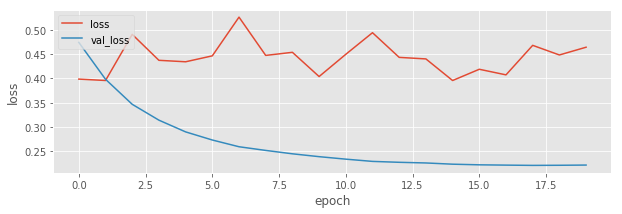

In [158]:
plot_hist(m_h, 'loss')

In [164]:
weights_file = 'm_p%2d_%.4f_%.4f' % (p*100, m_h.history['val_loss'][-1], m_h.history['val_acc'][-1])
m.save_weights(join(model_output_weights, weights_file))

In [168]:
# for _, i in enumerate(m.layers):
#     print(_, i.name)
# m.load_weights(join(model_output_weights, 'm_0.2732_0.9000'))
m.evaluate(x_test, y_test, batch_size=batch_size)
# m_h.history['val_loss']

160/160 [==============================] - 0s     


[0.22902444005012512,
 0.91874999999999996,
 0.85629631280899043,
 0.96734695434570317,
 0.90787483453750606]

In [173]:
# unfreezing the last 5 convolutional blocks

for layer in bm.layers[:52]:
    layer.trainable = False
for layer in bm.layers[52:]:
    layer.trainable = True

m.compile(Adam(), loss='binary_crossentropy', 
          metrics=['accuracy', recall, precision, fmeasure])

# m.load_weights(join(model_output_weights, 'm_0.2732_0.9000'))
# m.evaluate(x_test, y_test, batch_size=batch_size)

In [174]:
m.optimizer.lr = 0.0000000001; print(m.optimizer.lr)
batch_size = 128
epochs = 10

m_h = m.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
            validation_data=(x_test, y_test))

1e-10
Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 7s - loss: 0.3982 - acc: 0.8297 - recall: 0.8609 - precision: 0.8164 - fmeasure: 0.8371 - val_loss: 0.2423 - val_acc: 0.9187 - val_recall: 0.8463 - val_precision: 0.9833 - val_fmeasure: 0.9087
Epoch 2/10
640/640 [==============================] - 4s - loss: 0.4560 - acc: 0.8031 - recall: 0.8209 - precision: 0.7996 - fmeasure: 0.8093 - val_loss: 0.2429 - val_acc: 0.9187 - val_recall: 0.8463 - val_precision: 0.9833 - val_fmeasure: 0.9087
Epoch 3/10
640/640 [==============================] - 4s - loss: 0.4162 - acc: 0.8172 - recall: 0.8269 - precision: 0.8186 - fmeasure: 0.8211 - val_loss: 0.2433 - val_acc: 0.9187 - val_recall: 0.8463 - val_precision: 0.9833 - val_fmeasure: 0.9087
Epoch 4/10
640/640 [==============================] - 4s - loss: 0.4434 - acc: 0.8234 - recall: 0.8197 - precision: 0.8325 - fmeasure: 0.8243 - val_loss: 0.2437 - val_acc: 0.9187 - val_recall: 0.8463 - val_p

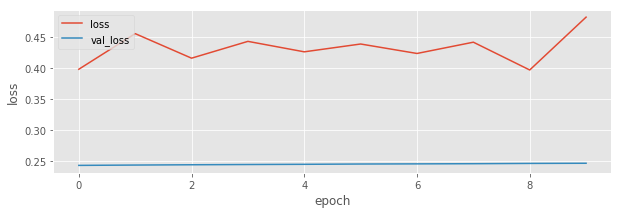

In [175]:
plot_hist(m_h, 'loss')

In [176]:
weights_file = 'm_p%2d_%.4f_%.4f' % (p*100, m_h.history['val_loss'][-1], m_h.history['val_acc'][-1])
m.save_weights(join(model_output_weights, weights_file))

[Table of contents](#top) [Bottom](#bot)
<a id='pred'.</a>

##### 0.5. Visualizing and saving predictions

Prediction: 
 [ 0.  0.  1.]
Label: 
 [ 0.  0.  1.]


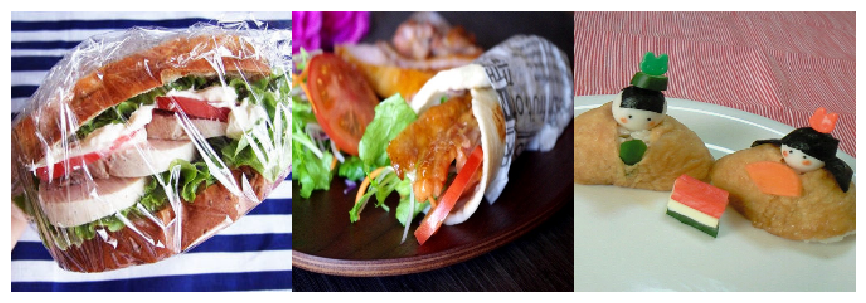

In [178]:
sample_ix = random.randint(0, x_test.shape[0])
print("Prediction: \n", np.round(m.predict(x_test[sample_ix:sample_ix+3])).ravel())
print("Label: \n", y_test[sample_ix:sample_ix+3])
plot_ims(x_test[sample_ix:sample_ix+3])

In [179]:
m_predictions = m.predict(x_test)
save_array(join(model_output, 'predictions'), m_predictions)

[Table of contents](#top) [Bottom](#bot)
<a id='bot'.</a>

END